In [36]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [49]:
import json
from nrclex import NRCLex
import nltk
nltk.data.path.append('/Users/pranaviyer/nltk_data')  # adjust path if needed

# Load stopwords
stopwords_path = './../../Data/stopwords/english'
with open(stopwords_path, 'r') as f:
    stopwords = f.read().splitlines()
    stop_words = set(stopwords)

def remove_stop_words(sentence):
    words = sentence.split()
    filtered_words = [word.strip('.,') for word in words if word.strip('.,') not in stop_words]
    return filtered_words

# Load signal data
signal_list_directory = './../../Data/keywords/all_signals.json'
with open(signal_list_directory, 'r') as f:
    signal_data = json.load(f)

# List to hold all emotion vector results
emotion_vector_results = []

def get_emotion_vector(signal):
    signal_id = signal['signal_id']
    descriptions = signal['emotional']['descriptions']# + signal['sensory']['descriptions'] + signal['associative']['descriptions']
    
    all_words = []
    emotion_word_counts = {
        'fear': 0,
        'anger': 0,
        'anticipation': 0,
        'trust': 0,
        'surprise': 0,
        'sadness': 0,
        'disgust': 0,
        'joy': 0,
        'negative': 0,
        'positive': 0 
    }

    for description in descriptions:
        words = remove_stop_words(description)
        all_words.extend(words)
        lex = NRCLex(" ".join(words))
        for emotion, count in lex.raw_emotion_scores.items():
            emotion_word_counts[emotion] = emotion_word_counts.get(emotion, 0) + 1

    total_emotion_words = len(descriptions) #sum(emotion_word_counts.values())
    
    emotion_vector = {}
    for emotion, count in emotion_word_counts.items():
        emotion_vector[emotion] = count / total_emotion_words if total_emotion_words > 0 else 0

    emotion_vector_results.append({
        "signal_id": signal_id,
        "emotion_vector": emotion_vector
    })

# Process all signals
for signal in signal_data:
    get_emotion_vector(signal)

# Write to JSON
with open('./emotion_vectors.json', 'w') as f:
    json.dump(emotion_vector_results, f, indent=2)

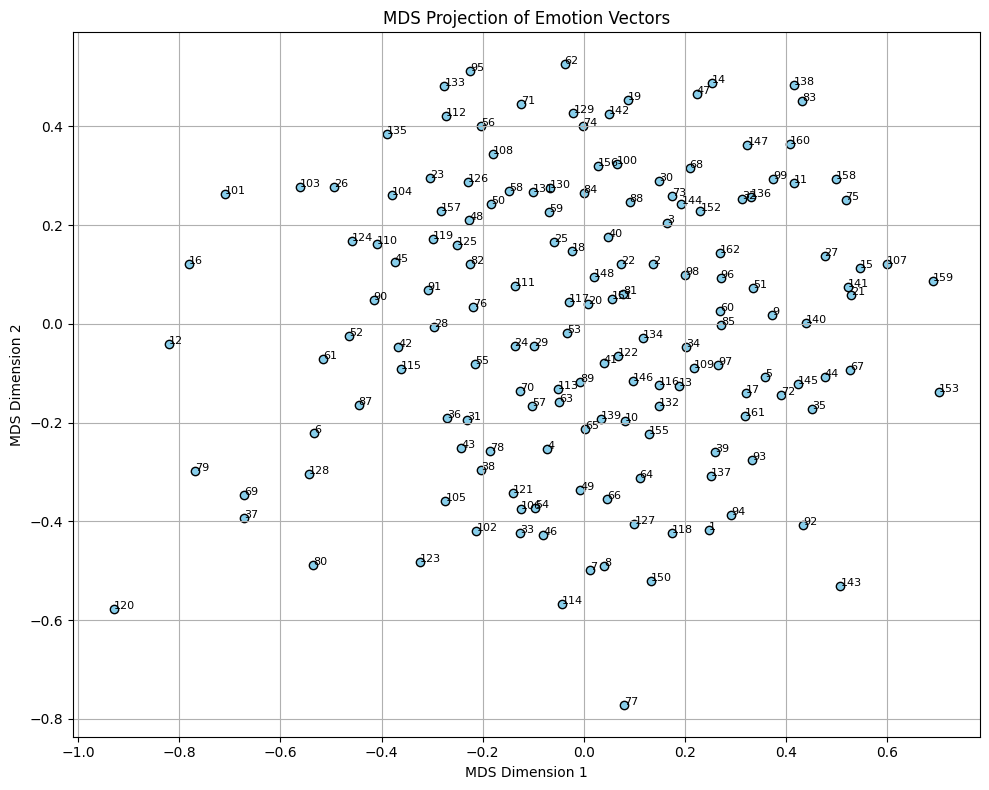

In [50]:
import json
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load emotion vectors from your JSON file
with open('./emotion_vectors.json', 'r') as f:
    data = json.load(f)

# Get signal IDs and emotion vectors
signal_ids = [item['signal_id'] for item in data]
emotion_vectors = [item['emotion_vector'] for item in data]

# Get all possible emotion labels in fixed order
all_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                'sadness', 'surprise', 'trust', 'negative', 'positive']

# Convert to a 2D matrix
vector_matrix = np.array([
    [vec.get(emotion, 0) for emotion in all_emotions]
    for vec in emotion_vectors
])

# Run MDS to reduce to 2D
mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
coords = mds.fit_transform(vector_matrix)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], c='skyblue', edgecolor='black')

# Annotate each point with signal_id
for i, signal_id in enumerate(signal_ids):
    plt.text(coords[i, 0], coords[i, 1], signal_id, fontsize=8)

plt.title("MDS Projection of Emotion Vectors")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

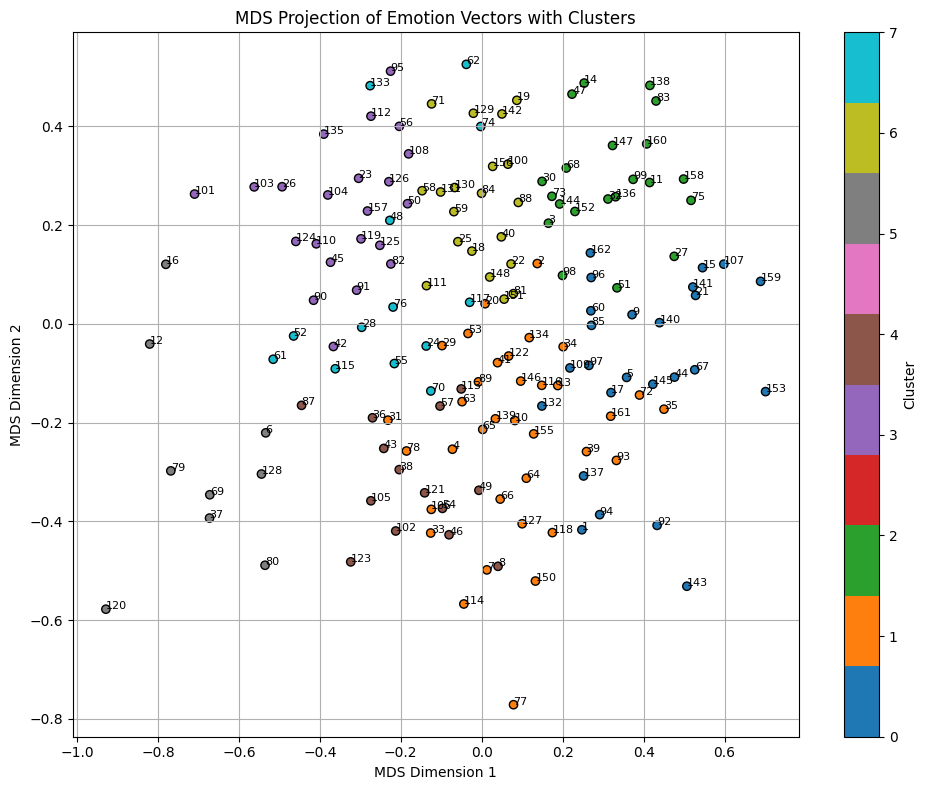

In [52]:
import json
import numpy as np
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load emotion vectors from your JSON file
with open('./emotion_vectors.json', 'r') as f:
    data = json.load(f)

# Get signal IDs and emotion vectors
signal_ids = [item['signal_id'] for item in data]
emotion_vectors = [item['emotion_vector'] for item in data]

# Get all possible emotion labels in fixed order
all_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                'sadness', 'surprise', 'trust', 'negative', 'positive']

# Convert to a 2D matrix
vector_matrix = np.array([
    [vec.get(emotion, 0) for emotion in all_emotions]
    for vec in emotion_vectors
])

# Run MDS to reduce to 2D
mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
coords = mds.fit_transform(vector_matrix)

# Run KMeans clustering
n_clusters = 8  # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(vector_matrix)

# Plot with clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap='tab10', edgecolor='black')

# Annotate each point with signal_id
for i, signal_id in enumerate(signal_ids):
    plt.text(coords[i, 0], coords[i, 1], signal_id, fontsize=8)

plt.title("MDS Projection of Emotion Vectors with Clusters")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.colorbar(scatter, label='Cluster')
plt.show()